# CS596 final project

## Blind source separation with artificial neural networks

#### Authors
<pre style="font-size: 120%">
Daniel Correa Tucunduva  002228689
Siqian Liu               002240226
Weina Zhu                002242570
Yan Jiang                002271130
</pre>

#### Credit
<pre style="font-size: 120%">
Data generation, fastICA and results plot code adapted from:
https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html

Neural network code adapted from:
https://raw.githubusercontent.com/abhijeet3922/Object-recognition-CIFAR-10/master/cifar10_90.py
</pre>

## Setup

In [1]:
# Hyperparameters

N = 20000  # time points for synthetic data generation for training
T = 10000  # time points for synthetic data generation for testing

epochs = 10
batch_size = 100

In [2]:
# Utility library

def random_weight():
    # a random weight in the range [0.01, 1.00]
    return round(np.random.randint(1, 101) / 100.0, 2)

def learning_rate_schedule(epoch):
    lrate = 0.001
    if epoch > 5:
        lrate = 0.0005
    return lrate

def save_generated_data_to_disk():
    # weights and observations have to be flattened to 2d arrays to allow saving as .csv
    flat_weights = np.zeros((GRID_ROWS * GRID_COLUMNS, 3))
    row = 0
    for i in range(GRID_ROWS):
        for j in range(GRID_COLUMNS):
            flat_weights[row] = weights[i][j]
            row += 1
    
    flat_observations = np.zeros((N + T, GRID_ROWS * GRID_COLUMNS))
    for nt in range(N + T):
        flat_observations[nt] = np.ravel(observations[nt])
    
    np.savetxt('true_sources.csv', true_sources, delimiter=',', fmt='%1.2f')
    np.savetxt('true_sources_noisy.csv', true_sources_noisy, delimiter=',', fmt='%1.2f')
    np.savetxt('flat_weights.csv', flat_weights, delimiter=',', fmt='%1.2f')
    np.savetxt('flat_observations.csv', flat_observations, delimiter=',', fmt='%1.2f')

def save_cnn_to_disk():
    cnn_json = cnn.to_json()
    with open('cnn.json', 'w') as json_file:
        json_file.write(cnn_json)
    cnn.save_weights('cnn.h5')
    
def save_dense_network_to_disk():
    dense_json = dense.to_json()
    with open('dense.json', 'w') as json_file:
        json_file.write(dense_json)
    dense.save_weights('dense.h5')

In [3]:
# Module setup

print(__doc__)

import numpy as np

from scipy import signal

import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers
from keras.callbacks import LearningRateScheduler

from sklearn.decomposition import FastICA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

Automatically created module for IPython interactive environment


Using TensorFlow backend.


## Data generation

In [4]:
# Generate synthetic data

np.random.seed(0)

GRID_ROWS = 10
GRID_COLUMNS = 10

time = np.linspace(0, (N + T) // 1000, N + T)

s1 = np.sin(2 * time) # sinusoidal signal
s2 = np.sign(np.sin(3 * time)) # square signal
s3 = signal.sawtooth(2 * np.pi * time) # saw tooth signal

# limit generated values to two decimals
for nt in range(N + T):
    s1[nt] = round(s1[nt], 2)
    s2[nt] = round(s2[nt], 2)
    s3[nt] = round(s3[nt], 2)

# random non-zero weights
weights = np.zeros((GRID_ROWS, GRID_COLUMNS, 3))
for i in range(GRID_ROWS):
    for j in range(GRID_COLUMNS):
        weights[i][j][0] = random_weight()
        weights[i][j][1] = random_weight()
        weights[i][j][2] = random_weight()

true_sources = np.c_[s1, s2, s3] # [N + T x 3], from signal tracks
true_sources /= true_sources.std(axis=0) # standardize
true_sources_noisy = true_sources + 0.15 * np.random.normal(size=true_sources.shape) # add noise

# [N + T x 10 x 10], linear combinations of signals using random non-zero weights
observations = np.zeros((N + T, GRID_ROWS, GRID_COLUMNS, 1))
for nt in range(N + T):
    for i in range(GRID_ROWS):
        for j in range(GRID_COLUMNS):
            linear_combination = weights[i][j][0] * true_sources_noisy[nt][0] + weights[i][j][1] * true_sources_noisy[nt][1] + weights[i][j][2] * true_sources_noisy[nt][2]
            observations[nt][i][j][0] = round(linear_combination, 2)

print('True sources shape: ', true_sources.shape)
print('Weights shape: ', weights.shape)
print('Observations shape: ', observations.shape)

save_generated_data_to_disk()

True sources shape:  (30000, 3)
Weights shape:  (10, 10, 3)
Observations shape:  (30000, 10, 10, 1)


In [5]:
# Split data into training and testing

true_sources_train = true_sources[:N]
true_sources_test = true_sources[N:]

true_sources_noisy_train = true_sources_noisy[:N]
true_sources_noisy_test = true_sources_noisy[N:]

observations_train = observations[:N]
observations_test = observations[N:]

print(true_sources_train.shape)
print(true_sources_test.shape)

(20000, 3)
(10000, 3)


## Neural networks and training

In [6]:
# CNN architecture

weight_decay = 1e-4
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=observations.shape[1:]))
cnn.add(Activation('elu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(32, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
cnn.add(Activation('elu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
cnn.add(Activation('elu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
cnn.add(Activation('elu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.3))
cnn.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
cnn.add(Activation('elu'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(64, (3, 3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
cnn.add(Activation('elu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.4))
cnn.add(Flatten())
cnn.add(Dense(3, activation='linear'))

cnn.summary()

optimizer_cnn = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
cnn.compile(loss='mean_squared_error', optimizer=optimizer_cnn)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 10, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 10, 10, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)         

In [7]:
# CNN training

generator = ImageDataGenerator()
history_cnn = cnn.fit_generator(
    generator.flow(observations_train, true_sources_noisy_train, batch_size=batch_size),
    steps_per_epoch=observations_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[LearningRateScheduler(learning_rate_schedule)]
)

save_cnn_to_disk()

Epoch 1/10
200/200 [==============================] - 13s 66ms/step - loss: 1.5959
Epoch 2/10
200/200 [==============================] - 12s 60ms/step - loss: 0.2689
Epoch 3/10
200/200 [==============================] - 12s 61ms/step - loss: 0.1201
Epoch 4/10
200/200 [==============================] - 12s 60ms/step - loss: 0.1094
Epoch 5/10
200/200 [==============================] - 13s 66ms/step - loss: 0.1114
Epoch 6/10
200/200 [==============================] - 13s 66ms/step - loss: 0.1171
Epoch 7/10
200/200 [==============================] - 14s 70ms/step - loss: 0.1172
Epoch 8/10
200/200 [==============================] - 14s 70ms/step - loss: 0.1196
Epoch 9/10
200/200 [==============================] - 14s 68ms/step - loss: 0.1212
Epoch 10/10
200/200 [==============================] - 13s 67ms/step - loss: 0.1248


In [8]:
# Dense architecture

dense = Sequential()
dense.add(Dense(32, input_shape=observations.shape[1:]))
dense.add(Dense(32))
dense.add(Dense(64))
dense.add(Dense(64))
dense.add(Dense(128))
dense.add(Dense(128))
dense.add(Flatten())
dense.add(Dense(3, activation='linear'))

dense.summary()

optimizer_dense = keras.optimizers.rmsprop(lr=0.001, decay=1e-6)
dense.compile(loss='mean_squared_error', optimizer=optimizer_dense)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 10, 10, 32)        64        
_________________________________________________________________
dense_3 (Dense)              (None, 10, 10, 32)        1056      
_________________________________________________________________
dense_4 (Dense)              (None, 10, 10, 64)        2112      
_________________________________________________________________
dense_5 (Dense)              (None, 10, 10, 64)        4160      
_________________________________________________________________
dense_6 (Dense)              (None, 10, 10, 128)       8320      
_________________________________________________________________
dense_7 (Dense)              (None, 10, 10, 128)       16512     
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)            

In [9]:
# Dense network training

generator = ImageDataGenerator()
history_dense = dense.fit_generator(
    generator.flow(observations_train, true_sources_noisy_train, batch_size=batch_size),
    steps_per_epoch=observations_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=[LearningRateScheduler(learning_rate_schedule)]
)

save_dense_network_to_disk()

Epoch 1/10
200/200 [==============================] - 4s 18ms/step - loss: 0.2181
Epoch 2/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0496
Epoch 3/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0313
Epoch 4/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0244
Epoch 5/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0184
Epoch 6/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0166
Epoch 7/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0027
Epoch 8/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0027
Epoch 9/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0026
Epoch 10/10
200/200 [==============================] - 3s 16ms/step - loss: 0.0023


## Network predictions for test data

In [10]:
# Compute CNN and Dense network predictions

# Compute CNN result 
signals_cnn = cnn.predict(observations_test)

# Compute Dense network result 
signals_dense = dense.predict(observations_test)

## ICA applied on entire data set (train + test)

In [11]:
# Compute ICA result

# Create [N + T x 100] track for ICA processing
ica_track = np.zeros((N + T, 100))
for nt in range(N + T):
    for i in range(10):
        for j in range(10):
            ica_track[nt][i * 10 + j] = observations[nt][i][j][0]

ica = FastICA(n_components=3)
signals_ica = ica.fit_transform(ica_track)  # Reconstruct signals
mixing_matrix_ica = ica.mixing_  # Get estimated mixing matrix

In [12]:
# Compute mean squared error for results

cnn_mean_squared_error = mean_squared_error(true_sources_noisy_test, signals_cnn)
dense_mean_squared_error = mean_squared_error(true_sources_noisy_test, signals_dense)
ica_mean_squared_error = mean_squared_error(true_sources_noisy, signals_ica)

## Results

In [13]:
print ('---------------------------------------------------------------')
print('CNN mean squared error on test data           : {}'.format(cnn_mean_squared_error))
print('Dense network mean squared error on test data : {}'.format(dense_mean_squared_error))
print('ICA mean squared error on entire data set     : {}'.format(ica_mean_squared_error))
print ('---------------------------------------------------------------')

---------------------------------------------------------------
CNN mean squared error on test data           : 0.008267692003063152
Dense network mean squared error on test data : 0.0001282048746893785
ICA mean squared error on entire data set     : 1.021278434682596
---------------------------------------------------------------


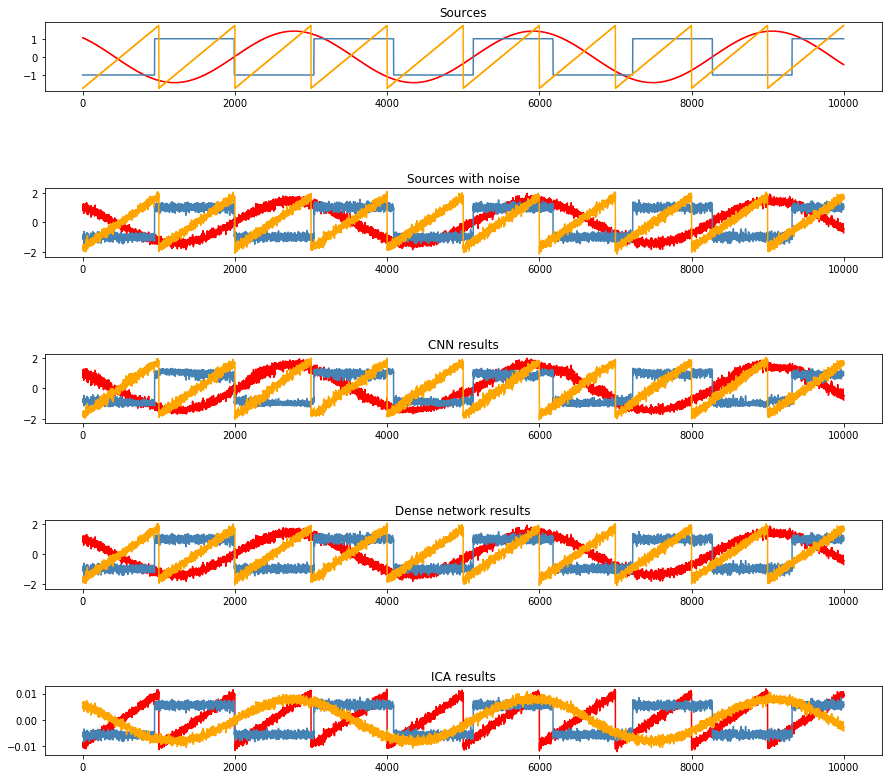

In [14]:
# Create plot of results

plt.figure(figsize=(15, 15))

models = [true_sources_test, true_sources_noisy_test, signals_cnn, signals_dense, signals_ica[N:]]
names = ['Sources', 'Sources with noise', 'CNN results', 'Dense network results', 'ICA results']
colors = ['red', 'steelblue', 'orange']

for index, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(10, 1, index * 2)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.show()
